<a href="https://colab.research.google.com/github/aime-n/ic/blob/main/GCN_link_prediction_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KG proposto para App Reviews
----

- app_id <-> snippet (relation='contain_snippet')
- app_id <-> category (relation='is_category')
- expressao1 <-> expressao2 (relation='relation') # OBS: vem do get_relation / get_entity
- snippet <-> requirement (relation='is_requirement')
- requirement <-> entity_group (relation='contain_tag')


OBS:
- Snippet é uma sentença da review.
- Ainda não temos a categoria, entao ignorar
- entity_group é uma maneira de agrupar os requisitos. Por exemplo, vários requisitos podem ser linkados com o entity_group = 'security'. Ainda não temos essa info, podemos ignorar.



# Functions

In [6]:
def edges_to_df(KG, rel='relation'):
  df_edges_linguistic = pd.DataFrame()

  source, target, relation = [], [], []
  for edge in KG.edges(data=True):
    source.append(edge[0])
    target.append(edge[1])
    relation.append(edge[2][rel])

  df_edges_linguistic['source'] = source
  df_edges_linguistic['relation'] = relation
  df_edges_linguistic['target'] = target

  return df_edges_linguistic

In [7]:
def matrix_adj(KG):
  adj_matrix = nx.adjacency_matrix(KG).todense()

  df_adj_matrix = pd.DataFrame(adj_matrix)

  df_adj_matrix['index'] = list(KG.nodes)
  df_adj_matrix.set_index('index', inplace=True)
  df_adj_matrix.columns = list(KG.nodes)

  return df_adj_matrix

In [8]:
def create_stellargraph(KG):
  df = edges_to_df(KG)
  matrix = matrix_adj(KG)

  G = sg.StellarGraph(matrix, df[['source', 'target']])
  
  return G

In [9]:
def gcn_function(SG, seed=42, epochs=50, show_metrics_untrained=False, show_metrics_trained=True, show_history=True):
  edge_splitter_test = EdgeSplitter(SG)
  G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
      p=0.1, method="global", keep_connected=False, seed=seed)
  
  edge_splitter_train = EdgeSplitter(G_test)
  G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
      p=0.1, method="global", keep_connected=False, seed=seed)
  
  train_gen = FullBatchLinkGenerator(G_train, method="gcn")
  train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

  test_gen = FullBatchLinkGenerator(G_test, method="gcn")
  test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

  gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3)
  
  x_inp, x_out = gcn.in_out_tensors()

  prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
  prediction = keras.layers.Reshape((-1,))(prediction)

  model = keras.Model(inputs=x_inp, outputs=prediction)
  model.compile(
      optimizer=keras.optimizers.Adam(lr=0.01),
      loss=keras.losses.binary_crossentropy,
      metrics=["binary_accuracy"],)

  init_train_metrics = model.evaluate(train_flow)
  init_test_metrics = model.evaluate(test_flow)

  if show_metrics_untrained == True:
    print("\nTrain Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

  history = model.fit(
      train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
  )

  if show_history == True:
    print(sg.utils.plot_history(history))

  train_metrics = model.evaluate(train_flow)
  test_metrics = model.evaluate(test_flow)

  if show_metrics_trained == True:
    print("\nTrain Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, train_metrics):
        print("\t{}: {:0.4f}".format(name, val))
        train_acc = val


    print("\nTest Set Metrics of the trained model:")
    for name, val in zip(model.metrics_names, test_metrics):
        print("\t{}: {:0.4f}".format(name, val))
        test_acc = val

  return round(train_acc, 5), round(test_acc, 5)

# KG atual para testes preliminares

- expressao1 <-> expressao2 (relation='relation') # OBS: vem do get_relation / get_entity
- snippet <-> requirement (relation='is_requirement')

## Knowledge Graph

### Libraries and functions for KG

In [10]:
!git clone https://github.com/HaoWeiHe/Knowledge-Graph

Cloning into 'Knowledge-Graph'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (428/428), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 428 (delta 242), reused 97 (delta 31), pack-reused 0
Receiving objects: 100% (428/428), 7.67 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [11]:
mv ./Knowledge-Graph/* .

In [12]:
from knowledgeGraph import get_entity
from knowledgeGraph import get_relation

- get_entity: <br>
Noun related tags (subject/object)
- get_relation: <br>
Dependency between them (predicate) <br><br>
Ex.:


Entities: ('milky way', 'spiral arms')
Relation: have


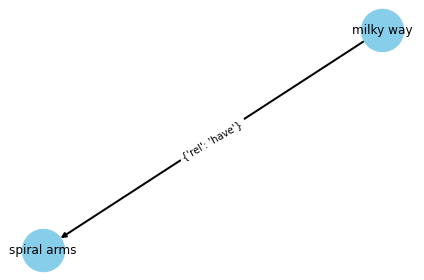

In [13]:
from knowledgeGraph import show
text = '''
The milky way has spiral arms'''
entities = get_entity(text)
rel = get_relation(text)
print(f'Entities: {entities}')
print(f'Relation: {rel}')
show(text)

In [14]:
# !pip install -q spacy==3.2 #NLP library

In [15]:
import pandas as pd

In [16]:
import nltk # Natural Language ToolKit
from nltk.tokenize import sent_tokenize # sentence tokenizer
nltk.download('punkt')
import networkx as nx # graph lib
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


- sent_tokenize: <br>
It splits the text into sentences. <br> <br>
Ex.: 

In [17]:
text = '''How happy is the blameless vestal's lot!
The world forgetting, by the world forgot.
Eternal sunshine of the spotless mind!
Each pray'r accepted, and each wish resign'd; '''

for sentence in sent_tokenize(text):
  print('-->', sentence)

--> How happy is the blameless vestal's lot!
--> The world forgetting, by the world forgot.
--> Eternal sunshine of the spotless mind!
--> Each pray'r accepted, and each wish resign'd;


### Original Data

In [18]:
ground_truth = pd.read_csv('https://raw.githubusercontent.com/aime-n/ic/main/Ground_truth.csv')
ground_truth.head()

App id  \
0  com.zentertain.photoeditor   
1  com.zentertain.photoeditor   
2  com.zentertain.photoeditor   
3  com.zentertain.photoeditor   
4  com.zentertain.photoeditor   

                                           Review id  Sentence id  \
0  gp:AOqpTOEW40L9WXqCjzq04bqaZImgMdzlczxIF3_ibs8...            1   
1  gp:AOqpTOF57AQPvmnCiWYurwLY-F2-mej25ON8RAFk-Ls...            1   
2  gp:AOqpTOHYdmt72q4tSD8TZ8A5fZQqGivlBkIbWuHuJMZ...            1   
3  gp:AOqpTOFYnXMShrDJPS0jpM04pFQxYOJN1LDuX3lSNm0...            1   
4  gp:AOqpTOF_JO496wnThQ2kcYlPct_g1GhOmQyyVvHp4VV...            1   

                                    Sentence content Feature (Positive)  \
0                                 May be i can check                NaN   
1                                   It make me happy                NaN   
2  I have a normal phone and it made 1 of my pics...                NaN   
3                                    Love it so much                NaN   
4                                Cant get to install                NaN   

  Feature (Neutral) Feature (Negative) Feature (All Annotated)  
0               NaN                NaN                     NaN  
1               NaN                NaN                     NaN  
2              pics                NaN                    pics  
3               NaN                NaN                     NaN  
4           install                NaN                 install

In [19]:
ground_truth['App id'].unique()

array(['com.zentertain.photoeditor', 'B004LOMB2Q', 'B004SIIBGU',
       'com.whatsapp', 'B005ZXWMUS', 'com.twitter.android', 'B0094BB4TW',
       'com.spotify.music'], dtype=object)

### Creation of KG

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stops = set(stopwords.words('english'))

def is_stopword(s):
  for w in s.split(' '):
    if w.lower() not in stops: return False

  return True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
KG = nx.Graph()
# index_l = []

i = 0
print('Print of the first 30 reviews:')
for review in tqdm(ground_truth['Sentence content']): 
  # tqdm => progress bar
  for sentence in sent_tokenize(review):
    if i < 30:
      print(f'--> {sentence}')

    nodes = get_entity(sentence) # (subject, object)
    sub, obj = nodes[0], nodes[1]

    rel = get_relation(sentence) # predicate

    # ignore less than 2 letter words
    if len(sub) > 2 and len(obj) > 2 and len(rel) > 2:
      if is_stopword(sub): continue
      if is_stopword(obj): continue
      if is_stopword(rel): continue
      # show(sentence)
      if i < 30:
        print(f'subject: {sub}\nrelation: {rel}\nobject: {obj}')
        i+=1
      # index_l.append(i)
      KG.add_edge(sub, obj, relation=rel)
      KG.add_edge(review, obj, relation='contains')
      KG.add_edge(review, sub, relation='contains')
      
  

Print of the first 30 reviews:


  0%|          | 0/2062 [00:00<?, ?it/s]

--> May be i can check
--> It make me happy
--> I have a normal phone and it made 1 of my pics look like one of a iphone 6 if u dont believe me look at my instagran account ... wings_2004
--> Love it so much
--> Cant get to install
--> Too many ads and secondly erratic interface.
--> I have already uninstalled
--> Its so happy
--> Nicest systematic for Android phones
--> Its so easy and fun
--> Main diss app tight um hmmm
--> Everything is awesome
--> I've downloaded a few different ones and this is easy to use, and the pictures come out great.
subject: pictures
relation: download
object: a few different ones
--> Plenty of options to choose from to make whatever kind of picture you would like
--> Like it but not so cool app
--> I really like the HD effect, brightness and color correction features.
--> I can basically change the whole pic   its so cool :-) lol :-)
--> I can't  believe  how easy  it is.
--> This app is very good for photos editer
--> It is just simple and Good app.
--> I

In [22]:
for i in list(KG.edges(data=True))[:10]:
  print(i)

('pictures', 'a few different ones', {'relation': 'download'})
('pictures', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'contains'})
('a few different ones', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'contains'})
('focus work.plz', 'samsung galaxy recntly a5', {'relation': 'use'})
('focus work.plz', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('samsung galaxy recntly a5', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('editing many options', 'photo editing', {'relation': 'recommend'})
('editing many options', 'lighter and faster than other photo editors ,with many editing options best recommended app 

In [23]:
for i in list(nx.connected_components(KG))[:10]:
  print(i)

{'pictures', 'a few different ones', "I've downloaded a few different ones and this is easy to use, and the pictures come out great."}
{'focus work.plz', 'samsung galaxy recntly a5', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!'}
{'photo editing', 'editing many options', 'lighter and faster than other photo editors ,with many editing options best recommended app for photo editing'}
{'super easy and i love the effects ,also super easy to install!!', 'effects', 'super i'}
{'best lot it', "I`ve seen so many photo editing tools but this one is the best 10x a lot it's really proffesional", 'photo editing so many tools'}
{'I love how this app syncs with all my devices, inc my phone and tablet.', 'just keyboard', 'frnds...every one should must install in your phone .', 'phone', 'app how syncs', 'I end up having to restart my phone just so the keyboard will minimize.', 'First why you', 'fine whe

In [24]:
print(f'Number of nodes: {len(KG.nodes)}')
print(f'Number of edges: {len(KG.edges)}')

Number of nodes: 567
Number of edges: 644


### Adicionando relacoes snippet <=> requirement

In [25]:
def isNaN(num):
    return num != num

for index,row in tqdm(ground_truth.iterrows(),total=len(ground_truth)):
  node1 = row['Sentence content']
  node2 = row['Feature (All Annotated)']
  if isNaN(node2)==False:
    for node in node2.split(';'):
      print(node)
      KG.add_edge(node1,node,relation='is_requirement')

  0%|          | 0/2062 [00:00<?, ?it/s]

pics
install
ads
interface
uninstalled
pictures
options to choose from
make whatever kind of picture
HD effect
brightness correction
color correction
change the whole pic
photos editer
splash functn
focus functn
make a video editor
book covers
photo editing
photo editors
editing
effects
install
ads
filters
Covers imperfections
ads popping up
ad pops up
photo editing
photo editing
take photo
add to photo
editing
effects
photo editor
effects
editor
Photo Editing
editing Photo's
edit pics
the results I get
make AMAZING photos
rate me pls' always pops out
airbrush feature
create amazing fotos
delete previously 'edited' needless photos
gallery
delete 'just those photos'
maintaining the original photo
frames
enhanced picture qualities
frames
detail options
frame options
adverts
photo editor
popups
option to un blur the blur photos
choose a photo
black screen came up
photo
add in another photo
photo
edit
perfects flaws
perfects inperfections
FONT
change the FONT Text
affects
download the stic

In [26]:
print(f'Number of nodes: {len(KG.nodes)}')
print(f'Number of edges: {len(KG.edges)}')

Number of nodes: 2547
Number of edges: 2137


### Verificando todas as conexoes da estrutura linguistica

In [27]:
for v in KG.edges(data=True):
  if v[2]['relation']!='is_requirement':
    print(v)

('pictures', 'a few different ones', {'relation': 'download'})
('a few different ones', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'relation': 'contains'})
('focus work.plz', 'samsung galaxy recntly a5', {'relation': 'use'})
('focus work.plz', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('samsung galaxy recntly a5', 'Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!', {'relation': 'contains'})
('editing many options', 'photo editing', {'relation': 'recommend'})
('editing many options', 'lighter and faster than other photo editors ,with many editing options best recommended app for photo editing', {'relation': 'contains'})
('super i', 'effects', {'relation': 'easy'})
('super i', 'super easy and i love the effects

### Verificando conexoes entre o KG linguistico e KG requisitos anotados

In [28]:
for v in KG.edges(data=True):
  if v[2]['relation']!='is_requirement':
    print(v)
    for v2 in KG.neighbors(v[0]):
      print("\t\t-->",v2)
    for v2 in KG.neighbors(v[1]):
      print("\t\t-->",v2)

Streaming output truncated to the last 5000 lines.
		--> The app is trying to talk with my smart TV.
		--> kindle first original fire
		--> When I first bought the original kindle fire this app wasn't too good.
		--> connection error
		--> I sat down today to continue watching my show when I opened the Netflix app, or I should say that I tried to open the app, but a connection error popped up.
		--> properly I
		--> I then checked other apps, they are working properly, so I decided to delete and reinstall the app.
		--> app
		--> Pradyut: I don't like this app because this app take several time
		--> restart
		--> This app locks keyboard to screen and requires restart.
		--> time I
		--> For some reason my keyboard glitches every time I use it in this app.
		--> update
		--> The app seems to get slower with every update.
		--> timeline
		--> This app is still not working, with no tweets showing in my timeline.
		--> fine standards
		--> This app worked fine by my standards.
		--> Disap

### OBS: os requisitos extraídos pelo BERT podem ser adicionados na rede da mesma forma dos anotados manualmente...

In [29]:
# def isNaN(num):
#     return num != num

# rebert_requisitos = CSV_REBERT
# for index,row in tqdm(rebert_requisitos.iterrows(),total=len(rebert_requisitos)):
#   node1 = row['Sentence content']
#   node2 = row['Feature (bert)'] # VERIFICAR
#   if isNaN(node2)==False:
#     for node in node2.split(';'):
#       print(node)
#       KG.add_edge(node1,node,relation='is_requirement')

### KG Visualization

A closer look.<br>
Drawing only the biggest chunk of connected nodes for visualization purpose

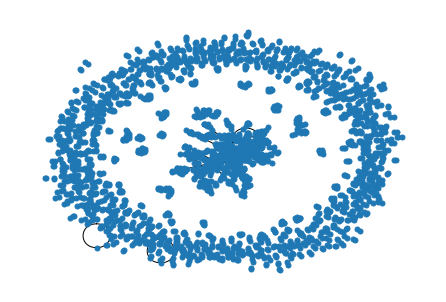

In [30]:
nx.draw(KG, node_size=25)

Number of nodes of the gcc: 568
Percentage of the original graph: 0.22300745975657638


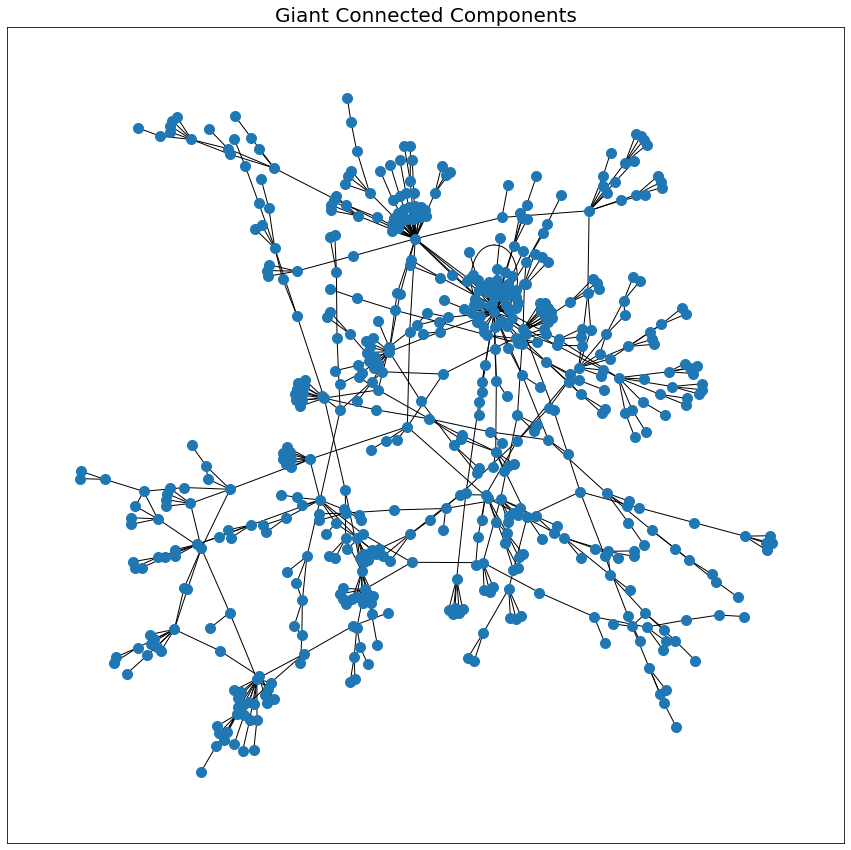

In [31]:
import matplotlib.pyplot as plt
gcc = (max(nx.connected_components(KG), key=len)) # giant connected component
subgraph_ = KG.subgraph(gcc)
print(f'Number of nodes of the gcc: {len(subgraph_.nodes)}')
print(f'Percentage of the original graph: {len(subgraph_.nodes)/len(KG.nodes)}')
options = {
    "font_size": 10,
    "node_size": 100,
}

plt.figure(figsize=(15,15)) 
nx.draw_networkx(subgraph_, **options, with_labels=False)
plt.title('Giant Connected Components', fontsize=20)
plt.show()

### Creation of DataFrame of edges

In [32]:
df_edges_linguistic = edges_to_df(KG)

In [33]:
df_edges_linguistic.head()

source        relation                                             target
0  pictures        download                               a few different ones
1  pictures  is_requirement  I've downloaded a few different ones and this ...
2  pictures  is_requirement  Well for one thing your app doesn't look anyth...
3  pictures  is_requirement  I save everything on Evernote, I mean pictures...
4  pictures  is_requirement  pictures are great since picture taking and de...

In [34]:
df_edges_linguistic.relation.unique()

array(['download', 'is_requirement', 'contains', 'use', 'recommend',
       'easy', 'see', 'need', 'love', 'frnd', 'end', 'get', 'work',
       'update', 'allow', 'change', 'find', 'mean', 'improve', 'make',
       'seem', 'try', 'buy', 'sit', 'like', 'lock', 'glitch', 'grate',
       'become', 'look', 'editing', 'nice', 'killer', 'help', 'wish',
       'appreciate', 'close', 'app', 'upgrade', 'fix', 'hold', 'note',
       'show', 'understand', 'write', 'save', 'consider', 'tweak', 'tend',
       'stuff', 'count', 'decide', 'post', 'keep', 'well', 'check',
       'ignore', 'time', 'sell', 'kill', 'call', 'slow', 'thank',
       'respond', 'appear', 'turn', 'clear', 'display', 'give', 'ask',
       'prefer', 'hang', 'happy', 'play', 'enjoy', 'stay', 'suck',
       'leave', 'area', 'want', 'tell', 'support', 'release', 'think',
       'put', 'reason', 'watch', 'FIX', 'load', 'take', 'exist', 'snd',
       'useless', 'FINE', 'issue', 'facebook', 'force', 'dump', 'bring',
       'choose', 

In [35]:
df_edges_linguistic.source.unique()

array(['pictures', 'a few different ones', 'focus work.plz', ...,
       'Even advertisement is not to frequent while enjoying my awesome Playlist.',
       'This app really awesome i can listen whatever music i want!',
       'I am fully connected to wifi and offline mode is off.'],
      dtype=object)

In [36]:
df_edges_linguistic.target.unique()

array(['a few different ones',
       "I've downloaded a few different ones and this is easy to use, and the pictures come out great.",
       "Well for one thing your app doesn't look anything like the pictures above and for another I got to edit one photo and then the app wouldn't open and kept force closing I hate it so I removed imedently",
       ..., 'advertisement', 'listen whatever music i want',
       'offline mode'], dtype=object)

In [37]:
print(f'Length of df edges linguistic: {len(df_edges_linguistic)}')

Length of df edges linguistic: 2137


### Matrix adjacency

In [38]:
df_adj_matrix = matrix_adj(KG)

df_adj_matrix.head()

pictures  \
index                                                          
pictures                                                   0   
a few different ones                                       1   
I've downloaded a few different ones and this i...         1   
focus work.plz                                             0   
samsung galaxy recntly a5                                  0   

                                                    a few different ones  \
index                                                                      
pictures                                                               1   
a few different ones                                                   0   
I've downloaded a few different ones and this i...                     1   
focus work.plz                                                         0   
samsung galaxy recntly a5                                              0   

                                                    I've downloaded a few different ones and this is easy to use, and the pictures come out great.  \
index                                                                                                                                                
pictures                                                                                            1                                                
a few different ones                                                                                1                                                
I've downloaded a few different ones and this i...                                                  0                                                
focus work.plz                                                                                      0                                                
samsung galaxy recntly a5                                                                           0                                                

                                                    focus work.plz  \
index                                                                
pictures                                                         0   
a few different ones                                             0   
I've downloaded a few different ones and this i...               0   
focus work.plz                                                   0   
samsung galaxy recntly a5                                        1   

                                                    samsung galaxy recntly a5  \
index                                                                           
pictures                                                                    0   
a few different ones                                                        0   
I've downloaded a few different ones and this i...                          0   
focus work.plz                                                              1   
samsung galaxy recntly a5                                                   0   

                                                    Ive used this on my previous phone.worked prrfectly but ive recntly bought samsung galaxy a5 the splash and focus functn doesnt work.plz help!!  \
index                                                                                                                                                                                                 
pictures                                                                                            0                                                                                                 
a few different ones                                                                                0                                                                                                 
I've downloaded a few different ones and this i...                                                  0                                                               

In [39]:
print(f'Matrix shape: {df_adj_matrix.shape}') # len(nodes) x len(nodes)

Matrix shape: (2547, 2547)


In [40]:
print(f'Is its length the same as the KG.nodes? {len(KG.nodes) == len(df_adj_matrix)}')

Is its length the same as the KG.nodes? True


## GCN implementation with matrix adjacency as feature

### Importing libraries for GCN

In [41]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 12.1 MB/s 
     |████████████████████████████████| 482 kB 31.7 MB/s 
     |████████████████████████████████| 462 kB 47.1 MB/s 
     |████████████████████████████████| 41 kB 515 kB/s 


In [42]:
import stellargraph as sg

In [43]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

### Building StellarGraph

In [44]:
G_adj = create_stellargraph(KG)

In [45]:
print(G_adj.info())

StellarGraph: Undirected multigraph
 Nodes: 2547, Edges: 2137

 Node types:
  default: [2547]
    Features: float32 vector, length 2547
    Edge types: default-default->default

 Edge types:
    default-default->default: [2137]
        Weights: all 1 (default)
        Features: none


### GCN algorithm

In [46]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G_adj)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42)

** Sampled 213 positive and 213 negative edges. **


In [47]:
G_test.number_of_nodes()

2547

In [48]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

** Sampled 192 positive and 192 negative edges. **


In [49]:
G_train.number_of_nodes()

2547

In [50]:
epochs = 50

In [51]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [52]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [53]:
len(edge_ids_test)

426

In [54]:
len(edge_labels_test)

426

In [55]:
edge_ids_test

array([['updated', "I've updated few days ago."],
       ['very useful you',
        'very useful app, you can note sonething in your mobile device then view it on your computer.'],
       ['Calling voice not clear', 'Calling voice'],
       ['photos', 'Can also download and print posted photos!'],
       ['news feed', 'Cannot see entire photo album from news feed.'],
       ['photos',
        'Evernote has exceptional file and information handling capabilities and allows you to capture, store and share not just notes but photos, webpages, freehand drawings and graphics, and pretty much anything you want.'],
       ["I like that a list of your activity on ebay is easy to see and manage and it doesn't move from your main search list.",
        'list of your activity'],
       ['sync issues with audio and severe video lag.',
        'sync issues with audio'],
       ['app', 'PC slightly differently version'],
       ['it.trust me',
        "netflix sucks and isn't the best for a kindle f

In [56]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [57]:
x_inp, x_out = gcn.in_out_tensors()

In [58]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [59]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [60]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [61]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 62ms/step - loss: 2.9884 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 3.0350
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.9884
	binary_accuracy: 0.5000


In [62]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 3.9894 - binary_accuracy: 0.5000 - val_loss: 2.1217 - val_binary_accuracy: 0.5000 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 2.0109 - binary_accuracy: 0.5000 - val_loss: 1.5970 - val_binary_accuracy: 0.5188 - 170ms/epoch - 170ms/step
Epoch 3/50
1/1 - 0s - loss: 1.4169 - binary_accuracy: 0.5078 - val_loss: 1.2459 - val_binary_accuracy: 0.5211 - 173ms/epoch - 173ms/step
Epoch 4/50
1/1 - 0s - loss: 1.0018 - binary_accuracy: 0.5260 - val_loss: 1.0640 - val_binary_accuracy: 0.5516 - 166ms/epoch - 166ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7182 - binary_accuracy: 0.5729 - val_loss: 0.9024 - val_binary_accuracy: 0.6033 - 185ms/epoch - 185ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6058 - binary_accuracy: 0.6953 - val_loss: 0.9904 - val_binary_accuracy: 0.6127 - 152ms/epoch - 152ms/step
Epoch 7/50
1/1 - 0s - loss: 0.6289 - binary_accuracy: 0.7656 - val_loss: 1.1113 - val_binary_accuracy: 0.6056 - 188ms/epoch - 188ms/step
Epoch 8/50
1/1 - 0s - loss: 0.5276 - binary_acc

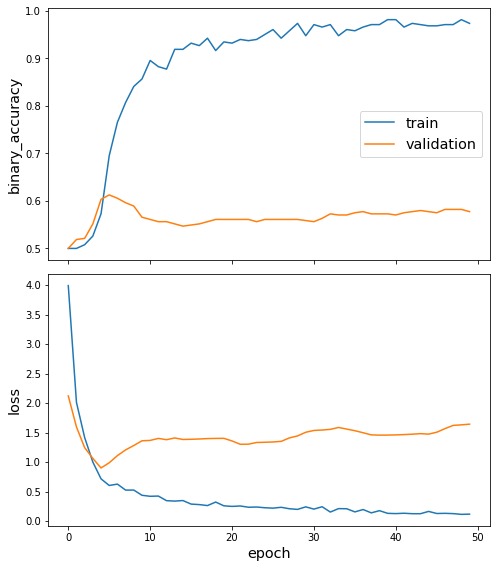

In [63]:
sg.utils.plot_history(history)

In [64]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 126ms/step - loss: 1.6435 - binary_accuracy: 0.5775

Train Set Metrics of the trained model:
	loss: 0.0744
	binary_accuracy: 0.9948

Test Set Metrics of the trained model:
	loss: 1.6435
	binary_accuracy: 0.5775


# Exemplo da Proposta: embutir features de um modelo de linguagem

## KG

### Functions and libraries

In [65]:
!pip install -q sentence-transformers

     |████████████████████████████████| 79 kB 3.3 MB/s 
     |████████████████████████████████| 3.8 MB 23.7 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 67 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 895 kB 33.6 MB/s 
     |████████████████████████████████| 6.5 MB 11.1 MB/s 


In [66]:
from sentence_transformers import SentenceTransformer

### Model.encode

In [67]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [68]:
feature_list = []
g_attr = KG.copy()

for node_id, node_feature in tqdm(g_attr.nodes(data=True)):
  feature_linguagem =  model.encode(node_id)
  feature_list.append(feature_linguagem)
  node_feature['embeddings'] = feature_linguagem
  # print(node_id)
  # print(feature_linguagem)

  0%|          | 0/2547 [00:00<?, ?it/s]

In [69]:
print('Último feature gerado:')
print('Node:',node_id)
print(feature_linguagem)

Último feature gerado:
Node: Works great for working out and premium is beyond worth it!!!!
[-3.09850246e-01 -3.04638386e-01 -1.99207366e-01 -2.70037144e-01
  2.06471443e-01 -1.62082389e-01 -1.10059403e-01  4.15548027e-01
 -3.57757807e-01 -6.07155621e-01 -4.48113948e-01  4.31607924e-02
 -2.84242868e-01 -9.90140662e-02 -2.71568503e-02 -1.98969498e-01
  8.08122158e-01  3.97292078e-02 -6.28324822e-02 -5.00883460e-01
 -2.58669674e-01 -5.50350964e-01 -4.23111200e-01  5.07218421e-01
 -1.09454870e-01  4.00032640e-01 -4.53910202e-01  3.22965942e-02
  2.59643316e-01 -1.98239908e-01 -2.58066710e-02 -1.15868390e-01
 -1.35839969e-01 -1.24801256e-01 -4.68550920e-01  3.50665659e-01
  1.89288631e-01 -3.50425124e-01 -1.57009870e-01 -1.32075533e-01
 -4.87675369e-02 -1.93270147e-01 -4.21920329e-01  3.81904282e-02
  1.54323038e-02  3.63840997e-01 -2.39815041e-01 -4.03980613e-01
  3.30459863e-01  3.66030872e-01  5.76594234e-01  1.58096015e-01
  4.09372836e-01  4.55237217e-02  1.31419316e-01  1.25799149e-0

In [70]:
# embeddings as feature of the first node
list(g_attr.nodes(data=True))[0]

('pictures',
 {'embeddings': array([-2.67976761e-01,  3.33682299e-01,  2.87214488e-01,  3.49370152e-01,
          4.52413291e-01,  2.11417794e-01,  4.16500807e-01,  8.54689479e-02,
          4.17735904e-01, -1.12989455e-01, -7.48506859e-02,  2.06178725e-02,
          4.66818243e-01,  1.38443904e-02, -5.76178551e-01,  8.50672796e-02,
          1.75763369e-01,  1.65468350e-01, -4.79465514e-01,  1.84457660e-01,
         -3.66264135e-01, -3.62785101e-01,  3.74950200e-01, -3.06625396e-01,
          3.18199277e-01,  1.90681592e-01, -4.38723922e-01,  2.45634302e-01,
         -3.05191100e-01, -1.08755648e+00,  6.54038265e-02, -1.73501626e-01,
         -1.06589325e-01,  1.41211241e-01,  6.70721054e-01,  4.38318044e-01,
         -4.16701466e-01,  3.50251436e-01, -1.39573470e-01,  2.94964343e-01,
         -3.41577791e-02, -2.27766439e-01,  1.12539232e-01,  7.19391927e-02,
         -3.27009521e-02,  5.30108772e-02, -2.31833622e-01, -3.78074855e-01,
          3.55878204e-01, -1.21210786e-02, -3.032

#### Exemplo de model.encode


In [71]:
# # model.encode function example
# embeddings = model.encode(text[:10])

# #Print the embeddings
# for sentence, embedding in zip(text[:10], embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

In [72]:
# print(len(embeddings))

In [73]:
# feature_linguagem

In [74]:
# len(feature_linguagem)

### Creation of StellarGraph


In [75]:
G_emb = sg.StellarGraph.from_networkx(g_attr, node_features="embeddings", edge_type_attr='relation')

In [76]:
print(G_emb.info())

StellarGraph: Undirected multigraph
 Nodes: 2547, Edges: 2137

 Node types:
  default: [2547]
    Features: float32 vector, length 384
    Edge types: default-FINE->default, default-FIX->default, default-allow->default, default-app->default, default-appear->default, ... (101 more)

 Edge types:
    default-is_requirement->default: [1517]
        Weights: all 1 (default)
        Features: none
    default-contains->default: [405]
        Weights: all 1 (default)
        Features: none
    default-work->default: [19]
        Weights: all 1 (default)
        Features: none
    default-love->default: [10]
        Weights: all 1 (default)
        Features: none
    default-make->default: [8]
        Weights: all 1 (default)
        Features: none
    default-use->default: [7]
        Weights: all 1 (default)
        Features: none
    default-need->default: [7]
        Weights: all 1 (default)
        Features: none
    default-find->default: [6]
        Weights: all 1 (default)
        Fea

In [77]:
for i, j in zip(G_emb.nodes(), G_emb.node_features()):
  print(i, j)

Streaming output truncated to the last 5000 lines.
  2.39113212e-01 -2.95168042e-01 -1.06723201e+00 -6.78334296e-01
  4.95846532e-02  2.24758267e-01 -2.57295877e-01  5.26783764e-02
  1.43283710e-01  4.72423196e-01 -1.03114218e-01  8.73577669e-02
 -4.09215428e-02  1.98731899e-01 -2.38997474e-01  2.03140795e-01
 -2.28671476e-01  1.92168534e-01 -2.39197806e-01  4.22937870e-01
 -6.50267303e-01  3.94691080e-01 -1.48338690e-01 -6.53061718e-02
 -3.28192502e-01 -2.50171989e-01 -9.06876549e-02  2.18490660e-01
 -1.06779255e-01  2.62185484e-01 -3.25090289e-01 -1.80309173e-02
  3.29335272e-01 -3.59725147e-01  8.29640701e-02  3.89477044e-01
 -8.65265369e-01  1.68540969e-01 -5.08919179e-01  1.63300574e-01
 -2.85681874e-01 -2.64307112e-01 -2.99236834e-01 -2.01741066e-02
 -1.56380031e-02 -9.76771116e-02 -7.20216408e-02 -1.54379457e-01
  4.97062691e-02 -6.96379900e-01  4.33127433e-01  4.01166052e-01
 -1.78208232e-01  1.88167766e-01 -2.00041413e-01  6.05964422e-01
 -2.14630947e-01 -6.77660480e-02 -8.087

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -4.93262112e-02 -8.06223080e-02  2.78776586e-01  1.36177123e-01
 -4.23889428e-01  2.59709686e-01  7.49499127e-02 -2.26627290e-01
  1.45802557e-01  1.96404591e-01  3.32821310e-01 -1.22437492e-01
 -5.82751855e-02 -5.62817156e-02 -1.27946913e-01  1.07887246e-01
  7.26288408e-02 -1.36622610e-02 -1.29161522e-01  3.09688896e-01
  1.93360448e-01 -2.90281117e-01 -7.93101266e-02 -1.16711482e-02
  1.01259366e-01  7.17613101e-02  3.93505216e-01  1.98035613e-01
 -1.47346035e-01  3.51991951e-02  2.22473443e-01  1.70177877e-01
  1.44661173e-01  1.92919210e-01  3.30828696e-01 -2.26041123e-01
 -3.39162648e-02  1.09662786e-01  2.01600324e-02  1.89925388e-01
 -4.29170519e-01 -2.34526351e-01  2.45443001e-01 -1.91766709e-01
 -1.54138312e-01  8.14145580e-02 -3.31928253e-01  3.42095047e-01
  1.18164763e-01  1.23076044e-01 -1.32010683e-01 -1.36465713e-01
  4.10099566e-01 -2.80772120e-01  7.47355297e-02 -1.71073318e-01
  3.06115478e-01 -8.21757838e-02  2.458

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -2.32339367e-01 -5.17511725e-01  4.56595927e-01  2.37875387e-01
 -3.85321915e-01 -4.45473492e-01  1.00495644e-01 -1.56466261e-01
  4.30072993e-01 -4.69690152e-02 -5.91313899e-01 -3.17697078e-01
 -4.32189643e-01 -3.32820892e-01  3.01618755e-01  2.31102690e-01
  4.33762401e-01 -3.81933868e-01  3.76938254e-01 -4.45796289e-02
  2.59819299e-01 -4.87727165e-01 -3.85877162e-01  2.78528392e-01]
predict what shows you will like [ 7.05856830e-03 -6.93400621e-01  5.10388076e-01 -4.53027010e-01
  3.13205242e-01  9.05789614e-01 -1.18644588e-01 -3.21500301e-01
 -1.96053416e-01  7.60139078e-02 -2.97374338e-01  6.38316199e-03
  2.19489411e-01 -1.55012012e-01  1.38333023e-01 -7.59934306e-01
  7.95283914e-01 -3.39521654e-02 -1.71154544e-01 -4.60350633e-01
 -1.19041383e-01 -4.59136255e-02  2.18514442e-01  7.70919248e-02
 -1.48509577e-01  5.64329214e-02  3.77992153e-01  1.12380393e-01
 -3.50838453e-01 -5.39828241e-01 -3.68497878e-01 -1.97012216e-01
  1.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -5.92965245e-01 -9.51238930e-01  1.92825541e-01  1.75331637e-01
  1.22508317e-01  2.59290218e-01 -2.26551324e-01  6.08636141e-01
 -5.86360022e-02 -6.10909522e-01 -2.04419717e-01  3.74542713e-01
 -2.10239470e-01 -2.32139379e-01 -5.25535131e-03  5.00927418e-02
 -5.01670301e-01  2.47070715e-01  8.57391357e-02  2.89687365e-01
 -1.19423032e-01  4.01361659e-02  3.00358951e-01 -6.60512984e-01
  4.12658788e-02 -9.15188551e-01 -1.25422224e-01 -7.49322996e-02
 -2.39172596e-02 -3.68192382e-02 -3.15364242e-01 -5.71773238e-02
 -1.43825844e-01 -7.03559101e-01  1.87020466e-01 -2.41910636e-01
  4.20006871e-01  2.86582373e-02 -4.80913788e-01  5.23459554e-01
 -1.89751480e-02  1.76187158e-02 -2.32247114e-02  1.59272552e-03
 -2.83736557e-01  7.45617151e-01  4.56426978e-01 -2.66864419e-01
 -3.15950453e-01  1.14822231e-01 -4.14980143e-01 -4.58081573e-01
 -5.07561453e-02  1.84377223e-01 -7.08121434e-02 -8.43339205e-01
  6.38968408e-01  2.77335644e-01  4.415

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [78]:
G_emb.to_networkx().edges(data=True)

MultiEdgeDataView([('pictures', 'a few different ones', {'label': 'download', 'weight': 1.0}), ('pictures', "I've downloaded a few different ones and this is easy to use, and the pictures come out great.", {'label': 'is_requirement', 'weight': 1.0}), ('pictures', "Well for one thing your app doesn't look anything like the pictures above and for another I got to edit one photo and then the app wouldn't open and kept force closing I hate it so I removed imedently", {'label': 'is_requirement', 'weight': 1.0}), ('pictures', 'I save everything on Evernote, I mean pictures, magazine clips, recipes, thoughts, you name it.', {'label': 'is_requirement', 'weight': 1.0}), ('pictures', 'pictures are great since picture taking and developing is getting to be a thing of the past, cell phones hold their pictures.', {'label': 'is_requirement', 'weight': 1.0}), ('pictures', "After the first 10 or so posts the rest just load as blue text without pictures and it doesn't change after refresh.", {'label': 

## GCN implementation

In [79]:
# Define an edge splitter on the or iginal graph G:
edge_splitter_test = EdgeSplitter(G_emb) # class

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42)

** Sampled 213 positive and 213 negative edges. **


- Negative edges = non-existent edges
- Positive edges = existing edges


**Sampling negatives:** \\
Two nodes are randomly selected at first. If they're not connected, the pair is considered negative. If connected, the process repeats.

**Sampling positives:** \\
Positive edges are sampled and then removed from the graph.
- keep_connected=True: the reduced graph remain connected. At first, the minimum spanning tree (MST) is calculated, they can't be sampled or removed. Other edges are then sampled at random.
- keep_connected=False: the reduced graph doesn't remain connected. Positive edges are sampled at random from full graph. MST isn't calculated.

OBS: \\
Minimum spanning tree (MST): it's undirected subgraph that connects all nodes with minimum total edge weight possible.

In [80]:
len(G_test.nodes())

2547

In [81]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

** Sampled 192 positive and 192 negative edges. **


In [82]:
G_train.number_of_nodes()

2547

In [83]:
epochs = 50

- Epoch: number of epochs means how many times you go through the entire training set. == number of iterations (if batch size is the entire training set)

- Batch size: n of samples processed before updating the model. It's a subset that goes through the model.

batches por epoch = training set / batch size

In [84]:
edge_labels_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [85]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")  # class
train_flow = train_gen.flow(edge_ids_train, edge_labels_train) # pair of nodes, labels (1=true link or 0=false link)

Using GCN (local pooling) filters...


In [86]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [87]:
len(edge_ids_test)

426

In [88]:
len(edge_labels_test)

426

In [89]:
edge_ids_test

array([['very useful you',
        'very useful app, you can note sonething in your mobile device then view it on your computer.'],
       ['it.trust me',
        "netflix sucks and isn't the best for a kindle fire.you shouldn't waste your money on it.trust me!!!!!!!"],
       ['Facebook full it',
        'Though this is the full Facebook app, it tends to lag behind in updates.'],
       ['3 app',
        'I can edit in many ways... It looks always perfect... so yea 3 thumbs up to this app'],
       ['hotel',
        "Especially if we are travelling I can check auctions of my husband's and that way he doesn't have to find a computer at the hotel immediately."],
       ['ebay', 'This app makes bidding on ebay fast and easy.'],
       ['# story&#34',
        'I cannot seem to ever get a Facebook session running without seeing &#34;error loading story&#34; message.'],
       ['content',
        'By this time I would have thought Netfix would have created a more robust app for viewing thei

In [90]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)



- the layer_sizes is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16-dimensional hidden node features at each layer.
- activations is a list of activations applied to each layer’s output
- dropout=0.3 specifies a 30% dropout at each layer.


In [91]:
x_inp, x_out = gcn.in_out_tensors()

In [92]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [93]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [94]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [95]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 66ms/step - loss: 0.9520 - binary_accuracy: 0.5305

Train Set Metrics of the initial (untrained) model:
	loss: 0.7548
	binary_accuracy: 0.6120

Test Set Metrics of the initial (untrained) model:
	loss: 0.9520
	binary_accuracy: 0.5305


In [96]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 0.8635 - binary_accuracy: 0.6380 - val_loss: 2.3862 - val_binary_accuracy: 0.4718 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 2.6850 - binary_accuracy: 0.5885 - val_loss: 0.9196 - val_binary_accuracy: 0.5329 - 72ms/epoch - 72ms/step
Epoch 3/50
1/1 - 0s - loss: 0.9117 - binary_accuracy: 0.6979 - val_loss: 1.0199 - val_binary_accuracy: 0.5376 - 72ms/epoch - 72ms/step
Epoch 4/50
1/1 - 0s - loss: 0.8080 - binary_accuracy: 0.6354 - val_loss: 1.0172 - val_binary_accuracy: 0.5634 - 72ms/epoch - 72ms/step
Epoch 5/50
1/1 - 0s - loss: 0.8869 - binary_accuracy: 0.6562 - val_loss: 0.8746 - val_binary_accuracy: 0.5962 - 82ms/epoch - 82ms/step
Epoch 6/50
1/1 - 0s - loss: 0.8973 - binary_accuracy: 0.6797 - val_loss: 0.8641 - val_binary_accuracy: 0.6174 - 72ms/epoch - 72ms/step
Epoch 7/50
1/1 - 0s - loss: 1.2820 - binary_accuracy: 0.6042 - val_loss: 0.8510 - val_binary_accuracy: 0.6033 - 73ms/epoch - 73ms/step
Epoch 8/50
1/1 - 0s - loss: 0.8939 - binary_accuracy: 0.664

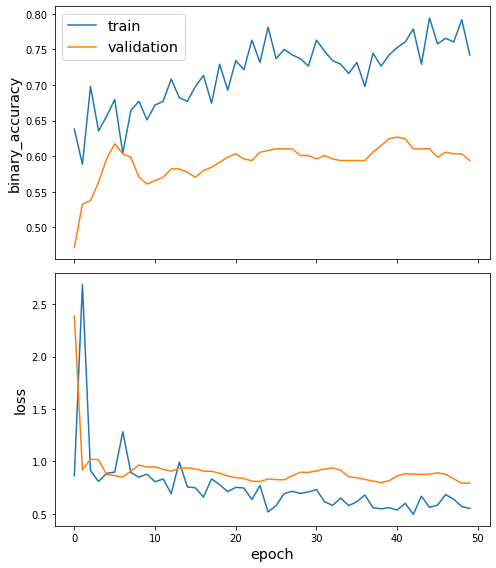

In [97]:
sg.utils.plot_history(history) #sigmoid

In [98]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 56ms/step - loss: 0.7936 - binary_accuracy: 0.5939

Train Set Metrics of the trained model:
	loss: 0.4252
	binary_accuracy: 0.8021

Test Set Metrics of the trained model:
	loss: 0.7936
	binary_accuracy: 0.5939


## Test with only "is_requirement" feature

In [126]:
def is_requirement(G):
  G_isreq = G.to_networkx(feature_name="embeddings", edge_type_attr="label").copy()

  not_isreq = [(u, v) for u,v,e in G_isreq.edges(data=True) if e["label"] != "is_requirement"]
  G_isreq.remove_edges_from(not_isreq)
  G_isreq = sg.StellarGraph.from_networkx(G_isreq, node_features="embeddings", edge_type_attr="label")

  return G_isreq

In [130]:
G_isreq = is_requirement(G_emb)
print(G_isreq.info()),
print(G_isreq.node_features()[10:])

StellarGraph: Undirected multigraph
 Nodes: 2547, Edges: 1517

 Node types:
  default: [2547]
    Features: float32 vector, length 384
    Edge types: default-is_requirement->default

 Edge types:
    default-is_requirement->default: [1517]
        Weights: all 1 (default)
        Features: none
[[-0.5892327  -0.2240727   1.0864947  ...  0.0298317  -0.14841102
   0.08624173]
 [-0.8198002  -0.05195777  0.44929495 ... -0.0162638  -0.05630503
   0.03528731]
 [ 0.37232772  0.44263768  0.28269523 ... -0.61725986 -0.02812902
   0.31519526]
 ...
 [-0.16482551  0.0917756  -0.01522038 ... -0.35851786 -0.17814058
  -0.23132908]
 [-0.23216021 -0.0548389  -0.1026999  ... -0.03604653 -0.8243737
  -0.14668496]
 [-0.30985025 -0.3046384  -0.19920737 ... -1.0786952  -0.22135791
   0.4467916 ]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: the 'feature_name' parameter has been replaced by 'feature_attr'
  


In [100]:
# Define an edge splitter on the original graph G:
edge_splitter_test2 = EdgeSplitter(G_isreq)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test2, edge_ids_test2, edge_labels_test2 = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42)

** Sampled 213 positive and 213 negative edges. **


In [101]:
test_gen2 = FullBatchLinkGenerator(G_test2, method="gcn")
test_flow2 = train_gen.flow(edge_ids_test2, edge_labels_test2)

Using GCN (local pooling) filters...


In [102]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 55ms/step - loss: 1.0069 - binary_accuracy: 0.5634

Train Set Metrics of the initial (untrained) model:
	loss: 0.4252
	binary_accuracy: 0.8021

Test Set Metrics of the initial (untrained) model:
	loss: 1.0069
	binary_accuracy: 0.5634


In [103]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 0s - loss: 0.5827 - binary_accuracy: 0.7630 - val_loss: 0.7974 - val_binary_accuracy: 0.5845 - 109ms/epoch - 109ms/step
Epoch 2/50
1/1 - 0s - loss: 0.5163 - binary_accuracy: 0.7734 - val_loss: 0.7942 - val_binary_accuracy: 0.5798 - 78ms/epoch - 78ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4880 - binary_accuracy: 0.7812 - val_loss: 0.7855 - val_binary_accuracy: 0.5845 - 83ms/epoch - 83ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5701 - binary_accuracy: 0.7552 - val_loss: 0.7737 - val_binary_accuracy: 0.5915 - 90ms/epoch - 90ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4506 - binary_accuracy: 0.7891 - val_loss: 0.7629 - val_binary_accuracy: 0.5939 - 78ms/epoch - 78ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4658 - binary_accuracy: 0.7734 - val_loss: 0.7526 - val_binary_accuracy: 0.6009 - 79ms/epoch - 79ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4237 - binary_accuracy: 0.8047 - val_loss: 0.7445 - val_binary_accuracy: 0.6056 - 92ms/epoch - 92ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4984 - binary_accuracy:

In [104]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 57ms/step - loss: 0.9089 - binary_accuracy: 0.6268

Train Set Metrics of the trained model:
	loss: 0.2999
	binary_accuracy: 0.8620

Test Set Metrics of the trained model:
	loss: 0.9089
	binary_accuracy: 0.6268


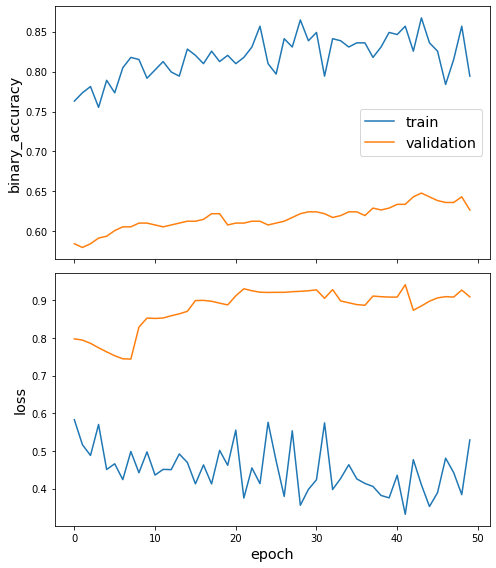

In [105]:
sg.utils.plot_history(history)

# Giant Connected Component

In [106]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [107]:
feature_list = []
G_sub = subgraph_.copy()

for node_id, node_feature in tqdm(subgraph_.nodes(data=True)):
  feature_linguagem =  model.encode(node_id)
  feature_list.append(feature_linguagem)
  node_feature['embeddings'] = feature_linguagem
  # print(node_id)
  # print(feature_linguagem)

  0%|          | 0/568 [00:00<?, ?it/s]

In [108]:
subgraph_.nodes(data=True)

NodeDataView({'Kindle fire well HD': {'embeddings': array([-1.92416355e-01, -3.21897445e-03,  2.04777107e-01, -1.37928888e-01,
        8.77653211e-02,  8.66324231e-02, -6.92672253e-01,  4.98834133e-01,
       -2.63109535e-01, -5.29062934e-02, -7.52539933e-01,  6.99960068e-02,
       -3.17873269e-01, -8.11975479e-01,  3.49494904e-01, -2.86063015e-01,
        3.97539198e-01, -5.94919324e-01, -1.01219885e-01,  5.61508775e-01,
        2.30210572e-01,  1.18274473e-01, -3.01500320e-01, -1.70606658e-01,
       -1.70223117e-01, -4.88952994e-02,  3.53401750e-01,  4.41973925e-01,
       -5.78771532e-01, -3.77061784e-01,  6.37667537e-01, -9.42167174e-03,
       -4.69675988e-01,  9.52449888e-02,  3.21302235e-01, -7.40217507e-01,
        1.69880629e-01, -3.24856967e-01, -4.99873340e-01, -5.06671965e-01,
       -2.84242690e-01,  3.02072585e-01,  3.05661023e-01,  6.85062483e-02,
       -4.99559231e-02,  8.93645212e-02, -6.42342202e-04, -3.81023675e-01,
        2.77727395e-01, -4.15818512e-01, -1.7972

In [109]:
subgraph_.edges(data=True)

EdgeDataView([('Kindle fire well HD', 'App', {'relation': 'work'}), ('Kindle fire well HD', 'App works well on my Kindle fire HD and my android devices.', {'relation': 'contains'}), ('receipts', 'I use it for everything--recipes, receipts, notes.of all kinds.', {'relation': 'is_requirement'}), ('way', 'slider', {'relation': 'open'}), ('way', 'Also you cant really open that menu for a song because the slider gets in the way.', {'relation': 'contains'}), ('way', 'artists', {'relation': 'understand'}), ('way', 'I understand you need a way to get more money and for the artists to not get cheated in a way.', {'relation': 'contains'}), ('I loved the Spotify app until the recent updates.', 'updates', {'relation': 'is_requirement'}), ("It's a great app and all but it keeps crashing again and again... I have to uninstall and install it once again.", 'uninstall', {'relation': 'is_requirement'}), ("It's a great app and all but it keeps crashing again and again... I have to uninstall and install i

In [110]:
# df_edges_linguistic = edges_to_df(subgraph_)
# df_adj_matrix = matrix_adj(subgraph_)

In [111]:
G_sub = sg.StellarGraph.from_networkx(subgraph_, node_features="embeddings", edge_type_attr='relation')
print(G_sub.info())

StellarGraph: Undirected multigraph
 Nodes: 568, Edges: 677

 Node types:
  default: [568]
    Features: float32 vector, length 384
    Edge types: default-allow->default, default-app->default, default-appreciate->default, default-become->default, default-buy->default, ... (51 more)

 Edge types:
    default-is_requirement->default: [410]
        Weights: all 1 (default)
        Features: none
    default-contains->default: [174]
        Weights: all 1 (default)
        Features: none
    default-work->default: [13]
        Weights: all 1 (default)
        Features: none
    default-need->default: [5]
        Weights: all 1 (default)
        Features: none
    default-love->default: [5]
        Weights: all 1 (default)
        Features: none
    default-use->default: [4]
        Weights: all 1 (default)
        Features: none
    default-make->default: [4]
        Weights: all 1 (default)
        Features: none
    default-update->default: [3]
        Weights: all 1 (default)
        F

In [112]:
print('Number of nodes: ', G_sub.number_of_nodes())
print('Number of edges: ', G_sub.number_of_edges())

Number of nodes:  568
Number of edges:  677


In [113]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G_sub)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42)

** Sampled 67 positive and 67 negative edges. **


In [114]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, seed=42
)

** Sampled 61 positive and 61 negative edges. **


In [115]:
epochs = 50

In [116]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [117]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [118]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [119]:
x_inp, x_out = gcn.in_out_tensors()

In [120]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [121]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [122]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [123]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 57ms/step - loss: 0.8932 - binary_accuracy: 0.5970

Train Set Metrics of the initial (untrained) model:
	loss: 0.7010
	binary_accuracy: 0.6230

Test Set Metrics of the initial (untrained) model:
	loss: 0.8932
	binary_accuracy: 0.5970


In [124]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 0.8006 - binary_accuracy: 0.6393 - val_loss: 3.1145 - val_binary_accuracy: 0.5224 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 3.3357 - binary_accuracy: 0.5410 - val_loss: 0.8951 - val_binary_accuracy: 0.6269 - 73ms/epoch - 73ms/step
Epoch 3/50
1/1 - 0s - loss: 0.8732 - binary_accuracy: 0.6967 - val_loss: 0.9059 - val_binary_accuracy: 0.5746 - 76ms/epoch - 76ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7276 - binary_accuracy: 0.6885 - val_loss: 0.8883 - val_binary_accuracy: 0.5896 - 74ms/epoch - 74ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4929 - binary_accuracy: 0.8033 - val_loss: 0.7987 - val_binary_accuracy: 0.6418 - 78ms/epoch - 78ms/step
Epoch 6/50
1/1 - 0s - loss: 0.6722 - binary_accuracy: 0.7213 - val_loss: 1.2106 - val_binary_accuracy: 0.6343 - 73ms/epoch - 73ms/step
Epoch 7/50
1/1 - 0s - loss: 0.7331 - binary_accuracy: 0.8115 - val_loss: 1.5497 - val_binary_accuracy: 0.6194 - 76ms/epoch - 76ms/step
Epoch 8/50
1/1 - 0s - loss: 0.8491 - binary_accuracy: 0.819

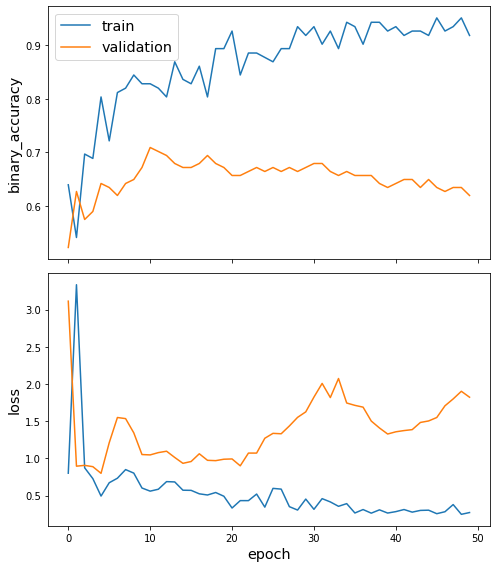

In [125]:
sg.utils.plot_history(history)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 51ms/step - loss: 1.7204 - binary_accuracy: 0.6716

Train Set Metrics of the trained model:
	loss: 0.1043
	binary_accuracy: 0.9672

Test Set Metrics of the trained model:
	loss: 1.7204
	binary_accuracy: 0.6716


In [127]:
G_sub_isreq = is_requirement(G_sub)

print(G_sub_isreq.info())

StellarGraph: Undirected multigraph
 Nodes: 568, Edges: 410

 Node types:
  default: [568]
    Features: float32 vector, length 384
    Edge types: default-is_requirement->default

 Edge types:
    default-is_requirement->default: [410]
        Weights: all 1 (default)
        Features: none


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: the 'feature_name' parameter has been replaced by 'feature_attr'
  


** Sampled 41 positive and 41 negative edges. **
** Sampled 36 positive and 36 negative edges. **
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 132ms/step - loss: 0.9834 - binary_accuracy: 0.5732
Epoch 1/50
1/1 - 3s - loss: 2.1601 - binary_accuracy: 0.5139 - val_loss: 0.9813 - val_binary_accuracy: 0.5732 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 1.0585 - binary_accuracy: 0.7083 - val_loss: 0.8151 - val_binary_accuracy: 0.5976 - 120ms/epoch - 120ms/step
Epoch 3/50
1/1 - 0s - loss: 1.3721 - binary_accuracy: 0.6528 - val_loss: 0.6060 - val_binary_accuracy: 0.6829 - 136ms/epoch - 136ms/step
Epoch 4/50
1/1 - 0s - loss: 1.2244 - binary_accuracy: 0.7083 - val_loss: 1.0015 - val_binary_accuracy: 0.7439 - 191ms/epoch - 191ms/step
Epoch 5/50
1/1 - 0s - loss: 1.0330 - binary_accuracy: 0.7361 - val_loss: 1.1538 - val_binary_accuracy: 0.7561 - 117ms/epoch - 117ms/step
Epoch 6/50
1/1 - 0s - loss: 0.7791 - binary_accuracy: 0.7917 - val_loss: 1.1719 - val_binary_accuracy: 0.7073 - 125ms/epoch - 125ms/step
Epoch 7/50
1/1 - 0s - loss: 0.8009 - binary_accuracy: 0.7639 - val_loss: 1.0654 - val_bina

(0.98611, 0.67073)

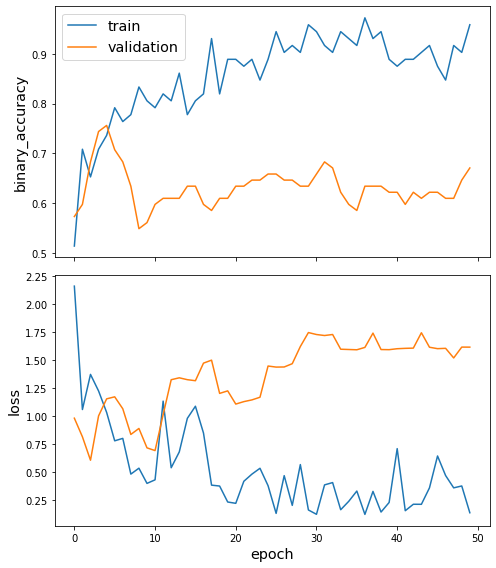

In [129]:
gcn_function(G_sub_isreq)